In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

from invisible_cities.io.pmaps_io      import load_pmaps
from invisible_cities.icaro.hst_functions    import shift_to_bin_centers
from invisible_cities.core.core_functions import weighted_mean_and_std
from invisible_cities.reco.tbl_functions import get_rwf_vectors

from collections import defaultdict

Running on  Wed Feb 21 12:41:44 2018


In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15

profOpt = "--k"
fitOpt  = "r"

### List of files

In [4]:
files = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/diffusion/waves/kr_rwf_*_0_7bar_NEXT_v1_00_05_v0.9.2_20171011_krmc_diomira.h5")

run = 4767

### Declare range and binnings

In [5]:
n_baseline = 48000

SBins = {'PMT_Baseline'     : [ np.linspace( 2300.,      2700.,   400 + 1) ],
         'PMT_BaselineRMS'  : [ np.linspace(    0.,        10.,   100 + 1) ],
         'SiPM_Baseline'    : [ np.linspace(    0.,       100.,   100 + 1) ],         
         'SiPM_BaselineRMS' : [ np.linspace(    0.,        10.,   100 + 1) ]}

SLabels = {'PMT_Baseline'     : ["ADCs"],
           'PMT_BaselineRMS'  : ["ADCs"],
           'SiPM_Baseline'    : ["ADCs"],
           'SiPM_BaselineRMS' : ["ADCs"]}

### Writer declaration

In [6]:
def hist_writer_var(file, *, compression = 'ZLIB4'):
    
    def write_hist(group_name  : 'options: HIST, HIST2D',
                   table_name  : 'histogram name',
                   entries     : 'np.array with bin content',
                   bins        : 'list of np.array of bins',
                   out_of_range: 'np.array lenght=2 with events out of range',
                   errors      : 'np.array with bins uncertainties',
                   labels      : 'list with labels of the histogram'):
        
        try:                       hist_group = getattr          (file.root, group_name)
        except tb.NoSuchNodeError: hist_group = file.create_group(file.root, group_name)

        if table_name in hist_group:
            raise ValueError("Histogram {} already exists".format(table_name))
            
        file.create_array(hist_group, table_name, entries)
        vlarray = file.create_vlarray(hist_group, table_name + '_bins', atom=tb.Float64Atom(shape=()))
        for ibin in bins:
            vlarray.append(np.array(ibin))
        file.create_array(hist_group, table_name + '_outRange', out_of_range)
        file.create_array(hist_group, table_name + '_errors', errors)
        file.create_array(hist_group, table_name + '_labels', labels)
                    
    return write_hist

### Monitoring class declaration

In [7]:
class MonParam:
    def __init__(self, bins, values=None):
        """
        This class is a parameter holder that contains data grouped by bins.
        
        Attributes:
    
        bins     = Dictionary with the histogram binning. 
                   Keys refer to each parameter being saved, values are arrays.
        data     = Dictionary with the accumulated counts on each bin. 
                   Keys refer to each parameter being saved, values are arrays.
        outRange = Dictionary with the accumulated counts out of the bin range. 
                   Keys refer to each parameter being saved, values are n-dim arrays
                   of lenght 2 (first element is underflow, second oveflow).
        errors   = Dictionary with the assigned uncertanties to each bin. 
                   Keys refer to each parameter being saved, values are arrays.
    
        Arguments:
    
        bins   = Dictionary with the histogram binning. 
                 Keys refer to each parameter being saved, values are arrays.
        values = Dictionary of arrays with initial values, optional. 
                 If not passed, then the initial bin content is set to zero.
        """
        self.bins = bins
                
        self.data = self.init_from_bins()
        self.outRange = {k: np.zeros((2,) * len(v)) for k, v in bins.items()}
        self.errors = self.init_from_bins()
        if values:
            self.Add(values)    

    def init_from_bins(self):
        return {k: np.zeros(shape=[len(x) - 1 for x in v]) for k, v in self.bins.items()}

    def add(self, additive):
        """
        Given a dictionary holding data (keys are parameters, values is 
        a list with the parameter values), bins it and adds it to the 
        stored bin content.
        
        additive = Dictionary holding the data to fill the histogram.
        """
        for attribute, value in additive.items():
            binnedData, outRange      = self.bin_data(np.asarray(value), self.bins[attribute])
            self.data[attribute]     += binnedData
            self.outRange[attribute] += outRange
            self.update_errors() #Not sure if we want to update automatically as it would overlap previous setted errors
            
    def bin_data(self, data, histbins): 
        """
        Bins the given data and computes the events out of range.
        """
        binned_data = np.histogramdd(data.T, histbins)[0]        
        if len(histbins) == 1:
            out_of_range = [len(data[data < histbins[0][0]]), len(data[data > histbins[0][-1]])]
        else:
            out_of_range = [[len(data[i][data[i] < bins[0]]), len(data[i][data[i] > bins[-1]])] for i, bins in enumerate(histbins)]

        return binned_data, out_of_range
    
    def update_errors(self, errors=None):
        """
        Updates the errors with the passed dictionary. If nothing is passed, then the 
        square root of the counts is computed and assigned as error.
        """        
        if errors:
            self.errors = errors
        else:
            self.errors = {k: np.sqrt(v) for k, v in self.data.items()} 

### Monitoring functions declaration

In [8]:
def add_histofiles(histofiles, sum_file):
    """
    Sums the histograms a given list of histogram files.
    
    histofiles = List of strings with the filenames to be summed.
    sum_file   = String with the name of the file containing the histograms sum.
    """
    
    if len(histofiles)<1:
        raise ValueError("List of files is empty")    

    with tb.open_file(histofiles[0], "r") as h5in:
        h5in.copy_file(sum_file,overwrite=True)
        
    if len(histofiles)>1:
        with tb.open_file(sum_file, "r+") as sum_out:
            
            for file in histofiles[1:]:
                with tb.open_file(file, "r") as h5in:
                    name_sel = lambda x: ('bins' not in x) and ('labels' not in x)
                    for name in filter(name_sel, list(sum_out.root.HIST._v_children)):
                        accumulated = getattr(sum_out.root.HIST, name)
                        additive    = getattr(h5in.root.HIST, name)
                        if 'errors' in name:
                            accumulated[:] = np.sqrt(accumulated[:] ** 2 + additive[:] ** 2)
                        else:
                            accumulated[:] = np.asarray(accumulated[:])  + np.asarray(additive[:])

In [9]:
def plot_from_file(histofile, histonames = 'all', plot_errors = False, save_pdf = [False, 'path']):
    """
    Plots the histograms of a given histogram file in a 3 column plot grid.
    
    histofile   = File containing the histograms.
    histonames  = List with histogram name to be plotted, if 'all', all histograms are plotted.
    plot_errors = Boolean. If true, plot the associated errors instead of the data.
    save_pdf    = Length 2 list, first element is a boolean. If true, saves the histograms
                  separately in pdf on the path passed as second element of the list.
    """    
    with tb.open_file(histofile, "r") as h5in:    

        if histonames == 'all':
            all_histos = list(h5in.root.HIST._v_children)
            histo_sel  = lambda x: ('bins' not in x) and ('labels' not in x) and ('errors' not in x) and ('outRange' not in x)
            histonames = list(filter(histo_sel, all_histos))
            
        nhistos = len(histonames)                

        if nhistos > 3:
            n_row = 3
        else: 
            n_row = nhistos
        
        nrows = nhistos // n_row
        if nhistos % n_row > 0:
            nrows +=1
            
        fig, axes = plt.subplots(nrows, n_row, figsize=(8 * n_row, 6 * nrows))
                
        for i, histoname in enumerate(histonames):
            bins      = getattr(h5in.root.HIST, histoname + '_bins')
            out_range = getattr(h5in.root.HIST, histoname + '_outRange')
            labels    = getattr(h5in.root.HIST, histoname + '_labels')
            labels    = [str(lab)[2:-1].replace('\\\\', '\\') for lab in labels]
            
            if plot_errors:
                entries = np.array(getattr(h5in.root.HIST, histoname + '_errors'))
            else:
                entries = np.array(getattr(h5in.root.HIST, histoname))

            if nhistos == 1:
                ax = axes
            elif nrows == 1:
                ax = axes[i % n_row]
            else:
                ax = axes[i // n_row][i % n_row]
                
            if len(bins) == 1:
                ax.bar(shift_to_bin_centers(bins[0]), entries, width=np.diff(bins[0]))
                ax.set_ylabel("Entries")

                out_range_string = 'Out range (%) = [{0:.2f}, {1:.2f}]'.format(100 * out_range[0] / np.sum(entries),
                                                                               100 * out_range[1] / np.sum(entries))
                mean = weighted_mean_and_std(shift_to_bin_centers(bins[0]), entries)
                ax.annotate('Mean = {0:.2f}\n'.format(mean[0]) +
                            'RMS = {0:.2f}\n' .format(mean[1]) +
                            out_range_string,
                            xy=(0.99, 0.99), xycoords='axes fraction',
                            fontsize=11,
                            horizontalalignment='right', verticalalignment='top') 
                
            elif len(bins) == 2:            
                ax.pcolormesh(bins[0], bins[1], entries.T)
                ax.set_ylabel(labels[1])

                out_range_stringX = 'Out range X (%) = [{0:.2f}, {1:.2f}]'.format(100 * out_range[0][0] / np.sum(entries),
                                                                                  100 * out_range[0][1] / np.sum(entries))
                out_range_stringY = 'Out range Y (%) = [{0:.2f}, {1:.2f}]'.format(100 * out_range[1][0] / np.sum(entries),
                                                                                  100 * out_range[1][1] / np.sum(entries))
                meanX = weighted_mean_and_std(shift_to_bin_centers(bins[0]), np.sum(entries, axis = 1)) 
                meanY = weighted_mean_and_std(shift_to_bin_centers(bins[1]), np.sum(entries, axis = 0))
                ax.annotate('Mean X = {0:.2f}\n'.format(meanX[0]) +
                            'Mean Y = {0:.2f}\n'.format(meanY[0]) +
                            'RMS X = {0:.2f}\n' .format(meanX[1]) +
                            'RMS Y = {0:.2f}\n' .format(meanY[1]) +
                            out_range_stringX + '\n' + out_range_stringY,
                            xy=(0.99, 0.99), xycoords='axes fraction',
                            fontsize=11, color='white',
                            horizontalalignment='right', verticalalignment='top') 

                
            ax.set_xlabel(labels[0])
            ax.set_title(histoname)
            
        fig.tight_layout()
        
        if save_pdf[0]:
            for i, histoname in enumerate(histonames):            
                if nhistos == 1:
                    ax = axes
                if nrows == 1:
                    ax = axes[i % n_row]
                else:
                    ax = axes[i // n_row][i % n_row]                
                extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(save_pdf[1] + histoname + '.png', bbox_inches=extent)


### Fill information (pmaps specific)

In [10]:
def fill_baseline (SVar, wfs, sensor_type):
    bls = np.mean(wfs, axis=1)[:, np.newaxis]
    rms = np.std (wfs, axis=1)[:, np.newaxis]
    SVar[sensor_type + '_Baseline']   .extend(bls.flatten())
    SVar[sensor_type + '_BaselineRMS'].extend(rms.flatten())                        

### File and event loop

In [11]:
output = "/Users/ansimez/Documents/InvCit/hdf5/histos_waveforms.h5"

SMon = MonParam(SBins)

for file in files[:]:
    with tb.open_file(file, "r") as h5in:
        SVar = defaultdict(list)

        nevt, pmtrwf, sipmrwf, _ = get_rwf_vectors(h5in)        
        for evt in range(nevt-9000):
            fill_baseline(SVar,  pmtrwf[evt][:,0:n_baseline],  "PMT")
            fill_baseline(SVar, sipmrwf[evt][:,0:n_baseline], "SiPM")
    
    SMon.add(SVar)

with tb.open_file(output, "w") as h5out:
    writer = hist_writer_var(h5out)    
    for param_name, bins in SMon.bins.items():    
        writer('HIST', param_name, SMon.data[param_name], bins, SMon.outRange[param_name],
               SMon.errors[param_name], SLabels[param_name])

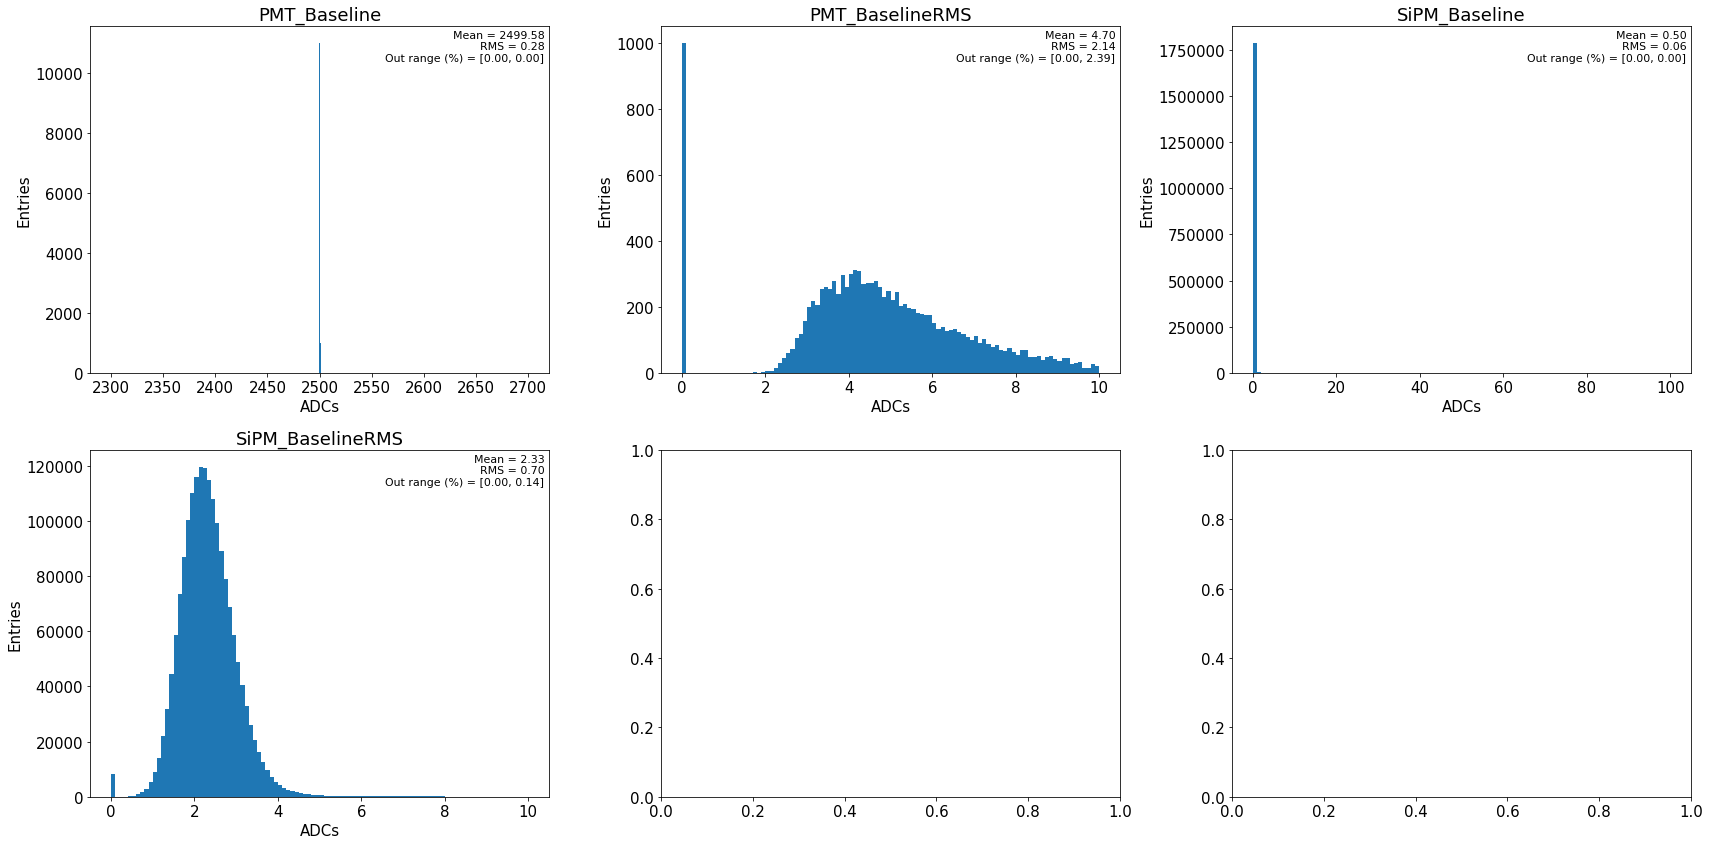

In [13]:
histofile = "/Users/ansimez/Documents/InvCit/hdf5/histos_waveforms.h5"
plot_from_file(histofile)